In [134]:
%matplotlib inline
import math
from modsim import *

For this model we're assuming that our mass begins in a geostationary orbit (perhaps a docking orbit for a cargo mission) and will be going to the moon. <br>
<br>
r0 = 42,164 km <br>
rf = 384,400 km <br>
<br>
To figure out what the necessary delta-v is we look at a Hohmann transfer.  Hohmann transfers are the most efficient means of switching circular orbits and involve two burns that sum to a net delta-v.  These are well-known, used, and documented calculations and explanations can be found readily online.  For this lab I used an online calculator found at the link below: <br>
<br>
https://instacalc.com/42836 <br>
<br>
According to this calculator the delta-v for the first maneuver is 956.61 m/s and for the second maneuver is 535.22 m/s, resulting in a net delta-v of 1491.83 m/s.  For this model, <b>1492 m/s is the target delta-v.</b>

In [125]:
r0 = 42164000    # in meters
rf = 384400000   # in meters
dv = 1492        # in meters/sec

Let's create a rocket object

In [126]:
vExhaust = 0     # Engine exhaust velocity
mDry = 1000      # Dry mass of the spacecraft (only rocket + payload)
mFuel = 0    # Mass of spacecraft fuel

rocket = System(vExhaust=vExhaust, mDry=mDry, mFuel=mFuel)

Let's initialize the exhaust velocities for a couple kinds of engines that our spacecraft could have. <br>
https://en.wikipedia.org/wiki/Specific_impulse#Examples <br>
https://en.wikipedia.org/wiki/Spacecraft_propulsion#Table_of_methods

In [142]:
SRB = 2500     # Space shuttle solid rocket booster
LH2 = 4400     # Liquid hydrogen rocket
Arc = 16000    # Arcjet rocket
PPT = 20000    # Pulsed plasma thruster
Ion = 29000    # Electrostatic ion thruster
Hall = 50000   # Electric Hall-effect thruster
Sail = 299792  # Solar sail (effectively no fuel)

engines = [SRB, LH2, Arc, PPT, Ion, Hall, Sail]    # Array of engines
initGuesses = [800, 400, 90, 70, 50, 20, 0]        # Array of initial guesses for each engine
names = ["SRB", "LH2", "Arc", "PPT", "Ion", "Hall", "Sail"]    # Array of engines

The below function solves for delta-v via a straight rocket equation calculation determined by a ratio of dry to wet masses given an exhaust velocity.

In [128]:
def solveV(r):
    
    # Calculate the change in velocity via the base rocket equation
    dv = r.vExhaust * math.log((r.mDry + r.mFuel) / r.mDry)
    
    return dv

The below function takes in a value for the mass of the rocket's fuel, solves for the dv achieved by that mass of fuel, and returns the difference between the achieved delta-v and the desired delta-v.

In [129]:
def error_func(mFuel):
    r = rocket
    r.mFuel = mFuel
    vf = solveV(r)

    return vf - dv    # Where dv is a reference to the target velocity

Let's pick an engine for the rocket and see what we can do with fsolve:

In [130]:
rocket.vExhaust = LH2

try:
    solution = fsolve(error_func, 400, xtol=1e-3)
except:
    print("Math range error")
    
solution[0]


404.67308281054034

By direct back-solving, the entire initial mass is 1404.7121, which means the fuel mass is 404.7121 so we're pretty close.<br>
http://www.quantumg.net/rocketeq.html
<br><br>
Cool, now let's try sweeping the engines:

In [165]:
for i in range(0, len(engines)):

    rocket.vExhaust = engines[i]
    initGuess = initGuesses[i]

    try:
        solution = fsolve(error_func, initGuess, xtol=1e-3)
    except:
        print("Math range error at index " + str(i))
        
    print("Engine " + str(i) + " requires " + str(solution[0]) + " kg of fuel")

Engine 0 requires 1633.31246448 kg of fuel
Engine 1 requires 807.671756814 kg of fuel
Engine 2 requires 195.432730893 kg of fuel
Engine 3 requires 155.127896679 kg of fuel
Engine 4 requires 106.441044216 kg of fuel
Engine 5 requires 61.330476861 kg of fuel
Engine 6 requires 10.2003835983 kg of fuel


C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


*** Turns out we get a lot of math errors because of fsolve *** <br><br>
But otherwise, great, glad it works! <br><br>Next we need to pick a single thruster and vary the dry mass of our spacecraft.

In [212]:
rocket.vExhaust = LH2
initGuess = 100             #initGuesses[engines.index(LH2)]

sweep = SweepSeries()

for mDry in linrange(1600, 6000, 200):   # Let's sweep 500-2000kg in increments of 100kg
    rocket.mDry = mDry 
    try:
        solution = fsolve(error_func, initGuess, xtol=1e-3)
    except:
        print("Math range error at index " + str(i))
        
    sweep[mDry] = solution[0]
    
print(sweep)

1600    149125.447190
1800    167766.828555
2000    186406.878264
2200    205047.373755
2400    223688.207178
2600    242328.844970
2800    260969.966391
3000    279609.615366
3200    298250.098771
3400    316890.973103
3600    335532.146738
3800    354173.062631
4000    372813.455126
4200    391454.209354
4400    410094.531645
4600    428735.100632
4800    447375.752987
5000    466017.104038
5200    484657.105796
5400    503298.125935
5600    521938.290488
5800    540579.179394
6000    559219.952238
dtype: float64


Now can we plot the results?

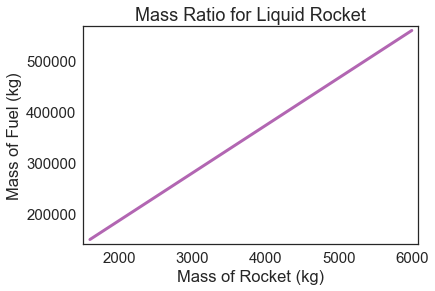

In [213]:
plot(sweep, color='purple')
decorate(title='Mass Ratio for Liquid Rocket',
         xlabel='Mass of Rocket (kg)',
         ylabel='Mass of Fuel (kg)',
         legend=False)

***  Hmm.  Let's think about if this is the right relationship or not  *** <br>
Cool.  Turns out this is the right result and that's because we can solve the rocket equation for mFuel and that yields the equation <b>mDry(e^(dv/vExhaust)-1)</b> which is linear while dv and vExhaust are constant
<br><br>
Next let's sweep this range for every engine and see what happens

In [215]:
frame = SweepFrame()
sweep = SweepSeries()

for i in range(0, len(engines)):

    rocket.vExhaust = engines[i]
    initGuess = initGuesses[i] * 0.1

    for mDry in linrange(1600, 6000, 200):   # Let's sweep 500-2000kg in increments of 100kg
        rocket.mDry = mDry 
        try:
            solution = fsolve(error_func, initGuess, xtol=1e-2)
        except:
            print("Math range error at index " + str(i))

        sweep[mDry] = solution[0]
    
    frame[names[i]] = sweep
        
frame

,SRB,LH2,Arc,PPT,Ion,Hall,Sail
1600,4.767893e+06,149123.927533,3985.461203,2749.466264,1589.588726,787.776042,110.755452
1800,5.363798e+06,167761.934663,4483.041050,3093.395679,1787.934720,885.769208,124.893798
2000,5.959604e+06,186396.574534,4980.897941,3437.339782,1986.436053,984.257114,138.005182
2200,6.555256e+06,205025.794966,5479.287212,3780.709753,2185.448353,1082.820951,152.138711
2400,7.151896e+06,223687.701737,5976.842168,4124.143471,2384.086354,1181.007982,165.218718
2600,7.747883e+06,242328.452433,6475.159853,4468.115722,2581.715584,1279.159526,179.636631
2800,8.343865e+06,260969.058193,6973.608559,4812.011625,2780.642882,1377.735866,193.287549
3000,8.939834e+06,279609.182237,7470.633329,5154.825285,2979.733789,1475.771018,207.523550
3200,9.535785e+06,298248.541337,7968.815311,5498.525530,3178.534215,1574.442313,221.749812
3400,1.013171e+07,316886.800254,8467.282199,5842.891782,3376.017277,1672.199726,235.643297


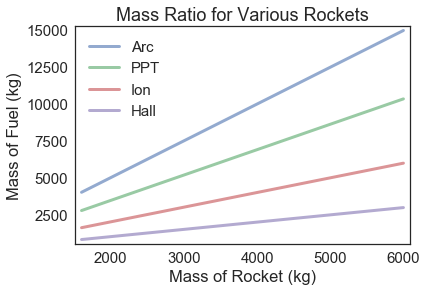

In [238]:
for i in range(2, len(engines)-1):
    label = names[i]
    plot(frame[label], label=label)

decorate(title='Mass Ratio for Various Rockets',
         xlabel='Mass of Rocket (kg)',
         ylabel='Mass of Fuel (kg)',
         legend=True)

*** Okay, now it's really time to check if linear is the right relationship or not *** <br><br>
But right now it's 2 in the morning and I'm done for the night (:

Actually wait I just had a guess at how to graph the real relationship we want and I'm listening to "Don't Stop Me Now" by Queen so I'm invincible and ready to finish this thing

In [225]:
finalFrame = SweepFrame()

for name in names:
    
    series = frame[name]
    temp = SweepSeries()
    dryMasses = series.index.tolist()
    fuelMasses = series.values.tolist()
    
    for i in range(0, len(dryMasses)-1):
        temp[dryMasses[i]] = dryMasses[i] + fuelMasses[i]
        
    finalFrame[name] = temp
        
finalFrame

,SRB,LH2,Arc,PPT,Ion,Hall,Sail
1600,4.769493e+06,150723.927533,5585.461203,4349.466264,3189.588726,2387.776042,1710.755452
1800,5.365598e+06,169561.934663,6283.041050,4893.395679,3587.934720,2685.769208,1924.893798
2000,5.961604e+06,188396.574534,6980.897941,5437.339782,3986.436053,2984.257114,2138.005182
2200,6.557456e+06,207225.794966,7679.287212,5980.709753,4385.448353,3282.820951,2352.138711
2400,7.154296e+06,226087.701737,8376.842168,6524.143471,4784.086354,3581.007982,2565.218718
2600,7.750483e+06,244928.452433,9075.159853,7068.115722,5181.715584,3879.159526,2779.636631
2800,8.346665e+06,263769.058193,9773.608559,7612.011625,5580.642882,4177.735866,2993.287549
3000,8.942834e+06,282609.182237,10470.633329,8154.825285,5979.733789,4475.771018,3207.523550
3200,9.538985e+06,301448.541337,11168.815311,8698.525530,6378.534215,4774.442313,3421.749812
3400,1.013511e+07,320286.800254,11867.282199,9242.891782,6776.017277,5072.199726,3635.643297


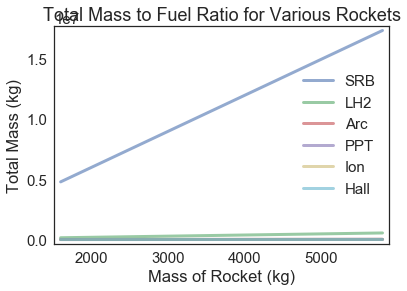

In [226]:
for i in range(0, len(engines)-1):
    label = names[i]
    plot(finalFrame[label], label=label)

decorate(title='Total Mass to Fuel Ratio for Various Rockets',
         xlabel='Mass of Rocket (kg)',
         ylabel='Total Mass (kg)',
         legend=True)

*** Hmm okay this is really interesting.  What are your thoughts about what we do next?  Check out the main graphic on this wikipedia page for the graph I was actually thinking of...***

https://en.wikipedia.org/wiki/Tsiolkovsky_rocket_equation

*** FYI, Connor Novak liked the graph before this one, he called it a good punchline graph ***


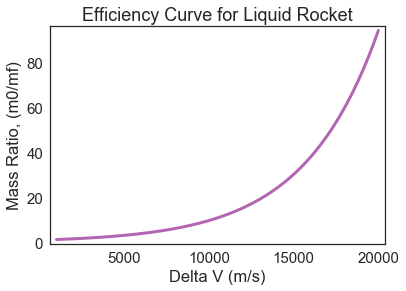

In [230]:
vExhaust = 0     # Engine exhaust velocity
mDry = 1600      # Dry mass of the spacecraft (only rocket + payload)
mFuel = 0    # Mass of spacecraft fuel
DV = 0

rocket = System(vExhaust=vExhaust, mDry=mDry, mFuel=mFuel)

rocket.vExhaust = LH2
initGuess = 100             #initGuesses[engines.index(LH2)]

sweep = SweepSeries()

for DV in linrange(1000, 20000, 100):   # Let's sweep 500-2000kg in increments of 100kg
    dv = DV
    try:
        solution = fsolve(error_func, initGuess, xtol=1e-3)
    except:
        print("Math range error at dv " + str(dv))
        
    mFuel = solution[0]
    #print(mFuel)
        
    sweep[dv] = (mDry + mFuel)/mDry


plot(sweep, color='purple')
decorate(title='Efficiency Curve for Liquid Rocket',
         xlabel='Delta V (m/s)',
         ylabel='Mass Ratio, (m0/mf)',
         legend=False)

In [231]:
vExhaust = 0     # Engine exhaust velocity
mDry = 1600      # Dry mass of the spacecraft (only rocket + payload)
mFuel = 0    # Mass of spacecraft fuel
DV = 0

rocket = System(vExhaust=vExhaust, mDry=mDry, mFuel=mFuel)

data = SweepFrame()

for i in range(0, len(engines)):

    rocket.vExhaust = engines[i]
    initGuess = initGuesses[i]/4           #initGuesses[engines.index(LH2)]

    sweep = SweepSeries()

    for DV in linrange(700, 5000, 100):   # Let's sweep 500-2000kg in increments of 100kg
        dv = DV
        try:
            solution = fsolve(error_func, initGuess, xtol=1e-3)
        except:
            print("Math range error at dv " + str(dv))

        mFuel = solution[0]

        sweep[dv] = (mDry + mFuel)/mDry
        
    data[names[i]] = sweep

C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


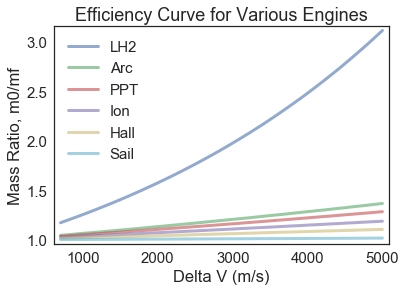

In [236]:
for i in range(1, len(engines)):
    label = names[i]
    plot(data[label], label=label)

decorate(title='Efficiency Curve for Various Engines',
         xlabel='Delta V (m/s)',
         ylabel='Mass Ratio, m0/mf',
         legend=True)

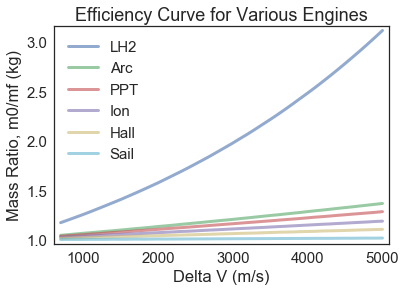

In [210]:
for i in range(1, len(engines)):
    label = names[i]
    plot(data[label], label=label)

decorate(title='Efficiency Curve for Various Engines',
         xlabel='Delta V (m/s)',
         ylabel='Mass Ratio, m0/mf (kg)',
         legend=True)